In [1]:
import pandas as pd
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from lib import helper
import random

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
image_size = 224

In [ ]:
# training data
train_x = pd.read_csv('train.zip')
train_y = pd.read_csv('train_labels.zip')
x_train = np.array(train_x)[:,1:].reshape((train_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y = np.array(train_y.iloc[:,1])

# validation data
val_x = pd.read_csv('val.zip')
val_y = pd.read_csv('val_labels.zip')


x_val = np.array(val_x)[:,1:].reshape((val_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y_val = np.array(val_y.iloc[:,1])


num_class = max(y) + 1

In [5]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [60]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), labels[indexes]

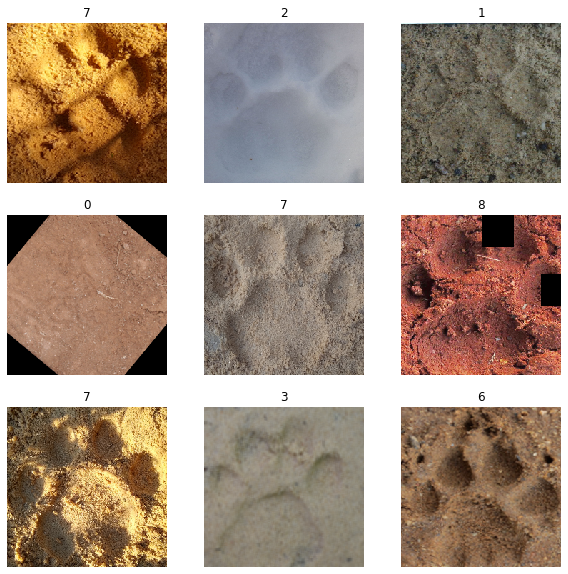

In [79]:
images = generator(x_train,y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(image[1][i])
    plt.axis("off")

In [4]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(num_class)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 13)                26637     
Total params: 20,888,117
Trainable params: 20,833,589
Non-trainable params: 54,528
_________________________________________________________________


In [108]:
# Model optimizer
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)

Epoch 1/100
46/45 [==============================] - 31s 671ms/step - loss: 5.6674 - accuracy: 0.1950 - val_loss: 3.3684 - val_accuracy: 0.2444 - lr: 5.0000e-04
Epoch 2/100
46/45 [==============================] - 30s 658ms/step - loss: 3.5710 - accuracy: 0.2582 - val_loss: 2.9637 - val_accuracy: 0.2917 - lr: 5.0000e-04
Epoch 3/100
46/45 [==============================] - 30s 659ms/step - loss: 3.1228 - accuracy: 0.2914 - val_loss: 2.2047 - val_accuracy: 0.3889 - lr: 5.0000e-04
Epoch 4/100
46/45 [==============================] - 30s 659ms/step - loss: 2.7069 - accuracy: 0.3461 - val_loss: 2.0660 - val_accuracy: 0.3722 - lr: 5.0000e-04
Epoch 5/100
46/45 [==============================] - 30s 663ms/step - loss: 2.3885 - accuracy: 0.3832 - val_loss: 1.8231 - val_accuracy: 0.4500 - lr: 5.0000e-04
Epoch 6/100
46/45 [==============================] - 30s 662ms/step - loss: 2.2791 - accuracy: 0.4096 - val_loss: 1.7294 - val_accuracy: 0.4500 - lr: 5.0000e-04
Epoch 7/100
46/45 [===============

In [109]:
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/100
46/45 [==============================] - 111s 2s/step - loss: 3.0689 - accuracy: 0.2408 - val_loss: 2.2648 - val_accuracy: 0.2889 - lr: 1.0000e-04
Epoch 2/100
46/45 [==============================] - 110s 2s/step - loss: 1.9310 - accuracy: 0.3604 - val_loss: 1.4693 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
46/45 [==============================] - 111s 2s/step - loss: 1.6051 - accuracy: 0.4504 - val_loss: 1.4331 - val_accuracy: 0.5056 - lr: 1.0000e-04
Epoch 4/100
46/45 [==============================] - 110s 2s/step - loss: 1.3462 - accuracy: 0.5516 - val_loss: 1.0061 - val_accuracy: 0.6583 - lr: 1.0000e-04
Epoch 5/100
46/45 [==============================] - 109s 2s/step - loss: 1.2421 - accuracy: 0.5856 - val_loss: 0.8957 - val_accuracy: 0.6944 - lr: 1.0000e-04
Epoch 6/100
46/45 [==============================] - 110s 2s/step - loss: 1.0096 - accuracy: 0.6624 - val_loss: 0.8441 - val_accuracy: 0.7028 - lr: 1.0000e-04
Epoch 7/100
46/45 [===========================

In [110]:
model.save('Xception.h5')

In [5]:
import tensorflow.keras as keras
model = keras.models.load_model('models/Xception_94.17.h5')

In [8]:
# validation data
val_x = pd.read_csv('val.zip')
val_y = pd.read_csv('val_labels.zip')

x_val = np.array(val_x)[:,1:].reshape((val_x.shape[0],image_size,image_size,3))[...,::-1].astype('uint8')
y_val = np.array(val_y.iloc[:,1])


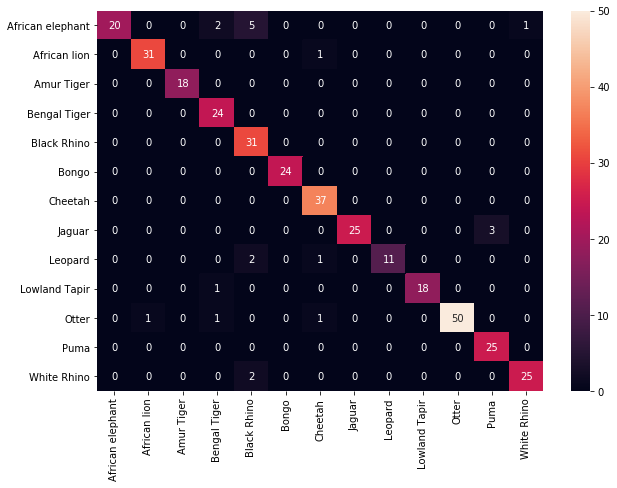

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['African elephant','African lion','Amur Tiger','Bengal Tiger', 'Black Rhino','Bongo' 
          ,'Cheetah','Jaguar','Leopard','Lowland Tapir', 'Otter','Puma','White Rhino']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)